In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import deconomix
from tqdm.notebook import tqdm

In [2]:
test, train = deconomix.utils.load_example()

# Prepare Test Data
# For each cell type (column), randomly select 50 genes and apply a random regulation factor (between 0.1 and 10)

test_regulated = test.copy()
np.random.seed(42)  # For reproducibility

for celltype in test_regulated.columns.unique():
    genes = test_regulated.index
    selected_genes = np.random.choice(genes, size=200, replace=False)
    regulation_factors = np.random.uniform(0.1, 10, size=200)
    test_regulated.loc[selected_genes, celltype] = (
        test_regulated.loc[selected_genes, celltype].values * regulation_factors[:, np.newaxis]
    )




Raw data already downloaded
Importing Data to Python ...
Using cached, preprocessed data
Done


In [3]:
print(test.size)
print(test.size - (test==test_regulated).sum().sum())

884000
47799


In [4]:
X_ref, Y_mat, C_mat = deconomix.utils.simulate_data(train, n_mixtures = 1000, n_cells_in_mix = 100)
_, Y_test, C_test = deconomix.utils.simulate_data(test_regulated, n_mixtures = 1000, n_cells_in_mix = 100)
model0 = deconomix.methods.DTD(X_ref, Y_mat, C_mat)
model0.run(iterations = 300)

  0%|          | 0/300 [00:00<?, ?it/s]

In [5]:
model_HPS = deconomix.experimental.HPS2(X_ref, Y_test, model0.gamma, 
                                        lambdas = np.logspace(-20, 0, num=21))

Preparing Job List
Preparing Baseline Model


  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
model_HPS.run(n_workers=24)

Running jobs: 100%|██████████| 105/105 [48:58<00:00, 27.98s/it] 


In [24]:


def plot_results(results):
    """
    Plot hyperparameter search results with error bars.

    Parameters
    ----------
    results : list of dict
        Each dict must have 'lambda', 'loss_raw', and 'loss_weighted' (per-fold results).
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert results (list of dicts) to DataFrame
    results_df = pd.DataFrame(results)

    # Group by lambda, compute mean and std per lambda
    grouped = results_df.groupby('lambda').agg({
        'loss_raw': ['mean', 'std'],
        'loss_weighted': ['mean', 'std']
    })
    #print(grouped)

    # Prepare X and error bars
    lambdas = np.array(grouped.index, dtype=float)
    loss_raw_mean = grouped[('loss_raw', 'mean')].values
    loss_raw_std = grouped[('loss_raw', 'std')].values
    loss_weighted_mean = grouped[('loss_weighted', 'mean')].values
    loss_weighted_std = grouped[('loss_weighted', 'std')].values

    # Plot with error bars on two separate subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Raw loss subplot
    axes[0].errorbar(lambdas, loss_raw_mean, yerr=loss_raw_std, 
                    label='Loss (raw)', marker='o', capsize=3, linestyle='-')
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Lambda')
    axes[0].set_ylabel('Loss (raw)')
    axes[0].set_title('Loss (raw) vs Lambda')
    axes[0].legend()

    # Weighted loss subplot
    axes[1].errorbar(lambdas, loss_weighted_mean, yerr=loss_weighted_std, 
                    label='Loss (weighted)', marker='s', capsize=3, linestyle='--')
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Lambda')
    axes[1].set_ylabel('Loss (weighted)')
    axes[1].set_title('Loss (weighted) vs Lambda')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

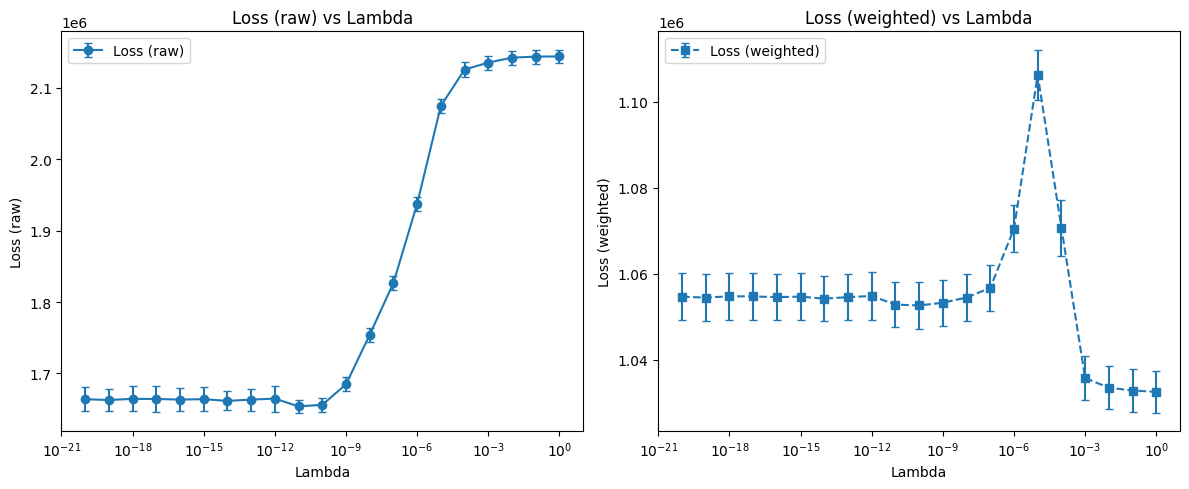

In [25]:
plot_results(model_HPS.results)

In [13]:
gamma_ones = model0.gamma.copy()
gamma_ones.iloc[:,0] = 1. / Y_test.shape[1] * np.ones(model0.gamma.shape[0]) / (Y_test.mean(axis=1))**2
gamma_ones

,gene weights
Genes,
HLA-DRA,0.000061
TYROBP,0.002972
NKG7,0.000108
IGFBP7,0.023944
FCER1G,0.006066
...,...
IMPDH2,0.000142
SAR1A,0.000131
RBMS3,0.005031


In [15]:
model_HPS_gamma_ones =  deconomix.experimental.HPS2(X_ref, Y_test, gamma_ones, 
                                        lambdas = np.logspace(-20, 0, num=21))

Preparing Job List
Preparing Baseline Model


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
model_HPS_gamma_ones.run()

Running jobs: 100%|██████████| 105/105 [09:22<00:00,  5.36s/it]


In [19]:
model_HPS_gamma_ones.results

[{'fold': 0,
  'lambda': np.float64(1e-12),
  'loss_raw': np.float64(2348393.804972262),
  'loss_weighted': np.float64(93.1980801696686)},
 {'fold': 0,
  'lambda': np.float64(1e-19),
  'loss_raw': np.float64(2368033.2581209242),
  'loss_weighted': np.float64(92.34112816057336)},
 {'fold': 0,
  'lambda': np.float64(1e-20),
  'loss_raw': np.float64(2368033.258436036),
  'loss_weighted': np.float64(92.34112804300321)},
 {'fold': 0,
  'lambda': np.float64(1e-14),
  'loss_raw': np.float64(2368002.2193629323),
  'loss_weighted': np.float64(92.35037540930577)},
 {'fold': 0,
  'lambda': np.float64(1e-11),
  'loss_raw': np.float64(2357700.8600806557),
  'loss_weighted': np.float64(94.3538265953872)},
 {'fold': 0,
  'lambda': np.float64(1e-16),
  'loss_raw': np.float64(2368032.892195181),
  'loss_weighted': np.float64(92.34128815519219)},
 {'fold': 0,
  'lambda': np.float64(9.999999999999999e-18),
  'loss_raw': np.float64(2368033.2229356673),
  'loss_weighted': np.float64(92.34114163650365)},
 {

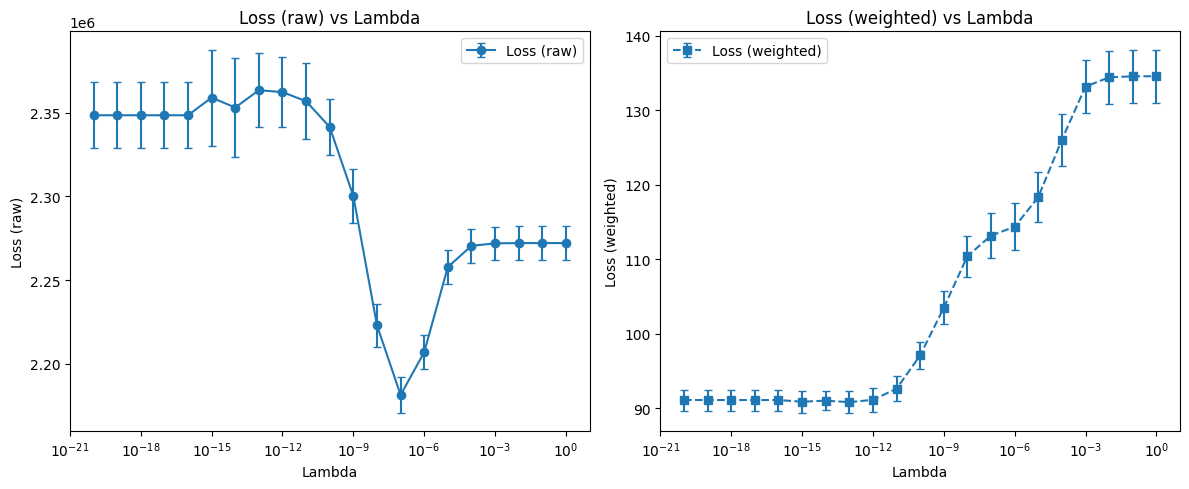

In [26]:
plot_results(model_HPS_gamma_ones.results)

In [ ]:
# res = [{'fold': 0, 'lambda': np.float64(1.0), 'loss': np.float64(2139471.844425775)},
#  {'fold': 1, 'lambda': np.float64(1.0), 'loss': np.float64(2135213.413829879)},
#  {'fold': 0,
#   'lambda': np.float64(0.1),
#   'loss': np.float64(2139286.0053564133)},
#  {'fold': 1,
#   'lambda': np.float64(0.1),
#   'loss': np.float64(2135027.5636956957)},
#  {'fold': 1, 'lambda': np.float64(0.01), 'loss': np.float64(2133524.07953183)},
#  {'fold': 0,
#   'lambda': np.float64(0.01),
#   'loss': np.float64(2137784.0752372276)},
#  {'fold': 1,
#   'lambda': np.float64(0.001),
#   'loss': np.float64(2126640.025862212)},
#  {'fold': 0,
#   'lambda': np.float64(0.001),
#   'loss': np.float64(2130889.0720230164)},
#  {'fold': 2,
#   'lambda': np.float64(0.01),
#   'loss': np.float64(2142962.8190079937)},
#  {'fold': 2,
#   'lambda': np.float64(0.1),
#   'loss': np.float64(2144493.2740077134)},
#  {'fold': 2, 'lambda': np.float64(1.0), 'loss': np.float64(2144682.564463103)},
#  {'fold': 2,
#   'lambda': np.float64(0.001),
#   'loss': np.float64(2135896.15322568)},
#  {'fold': 2,
#   'lambda': np.float64(0.0001),
#   'loss': np.float64(2125272.8961656312)},
#  {'fold': 1,
#   'lambda': np.float64(0.0001),
#   'loss': np.float64(2117021.2778523513)},
#  {'fold': 0,
#   'lambda': np.float64(0.0001),
#   'loss': np.float64(2121139.231507648)},
#  {'fold': 1,
#   'lambda': np.float64(9.999999999999999e-06),
#   'loss': np.float64(2063700.7738193215)},
#  {'fold': 2,
#   'lambda': np.float64(9.999999999999999e-06),
#   'loss': np.float64(2076197.894585333)},
#  {'fold': 0,
#   'lambda': np.float64(9.999999999999999e-06),
#   'loss': np.float64(2069394.4990858182)},
#  {'fold': 3,
#   'lambda': np.float64(0.01),
#   'loss': np.float64(2158438.0072551626)},
#  {'fold': 3,
#   'lambda': np.float64(0.1),
#   'loss': np.float64(2159928.7658153875)},
#  {'fold': 3,
#   'lambda': np.float64(1.0),
#   'loss': np.float64(2160113.7110028467)},
#  {'fold': 3,
#   'lambda': np.float64(0.001),
#   'loss': np.float64(2151701.5336599234)},
#  {'fold': 2,
#   'lambda': np.float64(1e-06),
#   'loss': np.float64(1939968.6554346103)},
#  {'fold': 2,
#   'lambda': np.float64(1e-09),
#   'loss': np.float64(1690923.8728735386)},
#  {'fold': 1,
#   'lambda': np.float64(1e-06),
#   'loss': np.float64(1926341.7907208328)},
#  {'fold': 0,
#   'lambda': np.float64(1e-06),
#   'loss': np.float64(1931532.5569261457)},
#  {'fold': 2,
#   'lambda': np.float64(1e-07),
#   'loss': np.float64(1829554.9213931125)},
#  {'fold': 2,
#   'lambda': np.float64(1e-10),
#   'loss': np.float64(1663021.473060064)},
#  {'fold': 0,
#   'lambda': np.float64(1e-08),
#   'loss': np.float64(1748318.89570477)},
#  {'fold': 4,
#   'lambda': np.float64(0.001),
#   'loss': np.float64(2130852.642368341)},
#  {'fold': 4, 'lambda': np.float64(0.1), 'loss': np.float64(2139281.194373258)},
#  {'fold': 4,
#   'lambda': np.float64(0.01),
#   'loss': np.float64(2137776.6908649392)},
#  {'fold': 1,
#   'lambda': np.float64(1e-07),
#   'loss': np.float64(1815156.5974996644)},
#  {'fold': 4,
#   'lambda': np.float64(1.0),
#   'loss': np.float64(2139467.2871986874)},
#  {'fold': 3,
#   'lambda': np.float64(0.0001),
#   'loss': np.float64(2142754.1967575075)},
#  {'fold': 0,
#   'lambda': np.float64(1e-09),
#   'loss': np.float64(1681271.1494576898)},
#  {'fold': 1,
#   'lambda': np.float64(1e-09),
#   'loss': np.float64(1673889.0776531196)},
#  {'fold': 2,
#   'lambda': np.float64(1e-08),
#   'loss': np.float64(1758198.043003267)},
#  {'fold': 0,
#   'lambda': np.float64(1e-10),
#   'loss': np.float64(1653013.8351463196)},
#  {'fold': 0,
#   'lambda': np.float64(1e-07),
#   'loss': np.float64(1820852.488357183)},
#  {'fold': 3,
#   'lambda': np.float64(1e-09),
#   'loss': np.float64(1698118.1484321286)},
#  {'fold': 3,
#   'lambda': np.float64(9.999999999999999e-06),
#   'loss': np.float64(2090652.6156276949)},
#  {'fold': 1,
#   'lambda': np.float64(1e-08),
#   'loss': np.float64(1742981.2489315323)},
#  {'fold': 1,
#   'lambda': np.float64(1e-10),
#   'loss': np.float64(1645760.7765087401)},
#  {'fold': 3,
#   'lambda': np.float64(1e-08),
#   'loss': np.float64(1768590.9850412726)},
#  {'fold': 3,
#   'lambda': np.float64(1e-10),
#   'loss': np.float64(1669850.3311386649)},
#  {'fold': 3,
#   'lambda': np.float64(1e-06),
#   'loss': np.float64(1953034.8048968816)},
#  {'fold': 4,
#   'lambda': np.float64(0.0001),
#   'loss': np.float64(2120734.5622159448)},
#  {'fold': 3,
#   'lambda': np.float64(1e-07),
#   'loss': np.float64(1841402.0898773326)},
#  {'fold': 4,
#   'lambda': np.float64(9.999999999999999e-06),
#   'loss': np.float64(2072103.6318508312)},
#  {'fold': 4,
#   'lambda': np.float64(1e-06),
#   'loss': np.float64(1935846.0285925358)},
#  {'fold': 4,
#   'lambda': np.float64(1e-10),
#   'loss': np.float64(1648831.4640684181)},
#  {'fold': 4,
#   'lambda': np.float64(1e-07),
#   'loss': np.float64(1826351.899117797)},
#  {'fold': 4,
#   'lambda': np.float64(1e-09),
#   'loss': np.float64(1679331.8836465196)},
#  {'fold': 4,
#   'lambda': np.float64(1e-08),
#   'loss': np.float64(1752246.508593064)}]


In [11]:
results_df = pd.DataFrame(np.zeros((5,11)), columns=np.logspace(-10, 0, num=11), index=range(5))

for result in res:
    results_df.loc[result['fold'], result['lambda']] = result['loss']


In [12]:
results_df

,1.000000e-10,1.000000e-09,1.000000e-08,1.000000e-07,1.000000e-06,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01,1.000000e+00
0,1.653014e+06,1.681271e+06,1.748319e+06,1.820852e+06,1.931533e+06,2.069394e+06,2.121139e+06,2.130889e+06,2.137784e+06,2.139286e+06,2.139472e+06
1,1.645761e+06,1.673889e+06,1.742981e+06,1.815157e+06,1.926342e+06,2.063701e+06,2.117021e+06,2.126640e+06,2.133524e+06,2.135028e+06,2.135213e+06
2,1.663021e+06,1.690924e+06,1.758198e+06,1.829555e+06,1.939969e+06,2.076198e+06,2.125273e+06,2.135896e+06,2.142963e+06,2.144493e+06,2.144683e+06
3,1.669850e+06,1.698118e+06,1.768591e+06,1.841402e+06,1.953035e+06,2.090653e+06,2.142754e+06,2.151702e+06,2.158438e+06,2.159929e+06,2.160114e+06
4,1.648831e+06,1.679332e+06,1.752247e+06,1.826352e+06,1.935846e+06,2.072104e+06,2.120735e+06,2.130853e+06,2.137777e+06,2.139281e+06,2.139467e+06


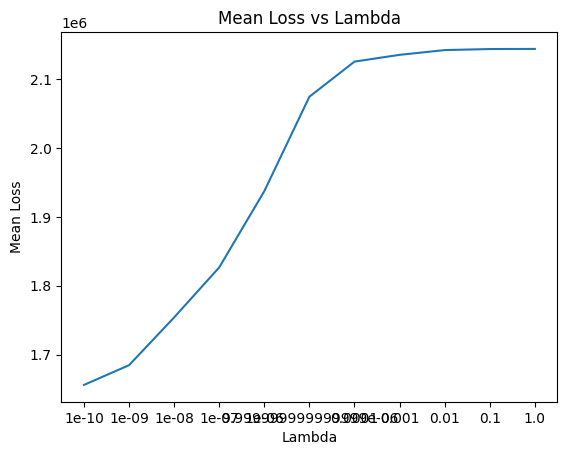

In [16]:
import matplotlib.pyplot as plt

mean_losses = results_df.mean(axis=0)

plt.plot(range(11), mean_losses)
plt.xlabel('Lambda')
plt.xticks(range(11), np.logspace(-10, 0, num=11))
plt.ylabel('Mean Loss')
plt.title('Mean Loss vs Lambda')
plt.show()

